$$\Large \text{Introduction}$$ 


In a near-future world where the line between organic warfare and artificial intelligence has all but disappeared, autonomous nations and militarized AIs are locked in a technological arms race. The battleground? Combat-optimized robotic gorillas highly engineered biomechanical units designed for both brute force and tactical adaptability. Gerald's company operates as a neutral manufacturer and supplier in this escalating human-versus-robot conflict, producing elite gorilla units for both sides. Gerald does not take sides; he delivers to the highest bidder. His business is called Northrop Gorilla. 


Each faction, whether a human-led coalition or an AGI-led autonomous military, submits multiple gorilla production requests per quarter. Each unit consists of multiple development stages, from chassis fabrication, structural welding, system integration. Every request includes a deadline, a revenue offer, a priority level tied to strategic importance, and detailed requirements for machines and worker teams. Every stage requires specific machines (e.g., Painter, Inspector), skilled workers, and materials such as Steel, Plastic, and Paint, all of which are tracked and constrained in our facility's inventory. Each client submits an order with a deadline, offered revenue, and a priority score reflecting its tactical urgency or political weight. Gerald also changes these priority skills based his relationship with the general submitting the request. For context, Gerald and General Perplexity are the best of mates. The opposite can be said of Gerald and General Grok.


Additionally, Northrop Gorilla must submit its earnings report in 30 days. What projects can Northrop Gorilla finish within that timeline?


We manage this process using two primary datasets:
`Projects_Data_with_Stage_Durations.csv`: Defines each 22 gorilla unit (project) requests, including stage-by-stage resource requirements (machines, workers, materials), duration in days, customer priority score, and total offered revenue.


`Locations_Capabilities.csv`: Describes the available resources at our factory — the inventory of Steel, Plastic, and Paint, the list of skilled workers with associated capabilities, and the available machines, each with defined functionalities and breakdown probabilities.


To schedule gorilla production efficiently, we implement a Mixed Integer Linear Program (MILP) using Julia and the JuMP framework. The model makes the following decisions:


1. Which gorilla orders to accept
2. When to begin each stage of each accepted order
3. Which machines and workers to assign to each stage
4. Whether a unit can be completed by its deadline without violating resource constraints


Modeling Assumptions
To keep the problem solvable under tight manufacturing timelines, we adopt the following simplifications:
Fixed stage durations: Each stage takes a known number of days with no variability or delay.


`No simulated breakdowns`: Although machines have associated breakdown probabilities, we assume full reliability during scheduling.


`Material usage is predefined`: Resource consumption per stage (Steel, Plastic, Paint) is fixed and known.

`Deadlines are strict`: Units not completed by the specified date yield no revenue.

$$\Large \text{Locations CSV Parsing}$$

Locations.csv is partitoned into the locations_data dictionary. A list of helper functions exist to traverse the dictionary.


In [1]:
using CSV
import Pkg
Pkg.add("JSON3")
using JSON3
using DataFrames


# Read the Locations CSV file
df = CSV.read("Locations_test.csv", DataFrame)

# Parses JSON strings into Julia objects
function parse_json_string(str)
    # Replace single quotes with double quotes 
    str = replace(str, "'" => "\"")
    return JSON3.read(str)
end

# Process each location's data
locations_data = Dict()

#Proceed through each row of the dataframe
for row in eachrow(df)
    location_id = row.Location_ID
    
    # Process workers data
    workers = parse_json_string(row.Workers)
    workers_dict = Dict()
    for worker in workers
        workers_dict[worker["Worker_ID"]] = Dict(
            "Capabilities" => worker["Capabilities"]
        )
    end
    
    # Process machines data
    machines = parse_json_string(row.Machines)
    machines_dict = Dict()
    for machine in machines
        machines_dict[machine["Machine_ID"]] = Dict(
            "Capabilities" => machine["Capabilities"],
            "Breakdown_Prob" => machine["Breakdown_Prob"]
        )
    end
    
    # Process inventory resources
    inventory = parse_json_string(row.Inventory_Resources)
    
    # Store all data for this location
    locations_data[location_id] = Dict(
        "workers" => workers_dict,
        "machines" => machines_dict,
        "inventory" => inventory
    )
end

# Finds all location ids
function get_all_location_ids()
    return collect(keys(locations_data))
end

# Finds all worker ids for a given location
function get_all_workers_ids(location_id)
    return collect(keys(locations_data[location_id]["workers"]))
end

# Finds the capabilities of a given worker
function get_worker_capabilities(location_id, worker_id)
    return locations_data[location_id]["workers"][worker_id]["Capabilities"]
end

# Finds all machine ids for a given location
function get_all_machines_ids(location_id)
    return collect(keys(locations_data[location_id]["machines"]))
end

# Finds the capabilities of a given machine
function get_machine_capabilities(location_id, machine_id)
    return locations_data[location_id]["machines"][machine_id]["Capabilities"]
end

# Finds all resource ids for a given location
function get_all_resources_ids(location_id)
    return sort(collect(keys(locations_data[location_id]["inventory"])))
end

# Finds the amount of a given resource for a given location
function get_resource_amounts(location_id, resource_id)
    return locations_data[location_id]["inventory"][resource_id]
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


get_resource_amounts (generic function with 1 method)

$$\Large \text{Projects CSV Parsing}$$

Projects.csv is partitoned into the projects_data dictionary. Each projects, holds a stage dicitonary that is traversable by the stage id. A list of helper functions exist to traverse the dictionary.

In [2]:
using CSV
using JSON3
using DataFrames

# Read the CSV file
df = CSV.read("Projects_test_updated.csv", DataFrame)

# Function to clean and parse JSON strings into Julia objects
function parse_json_string(str)
    # Clean the string: remove newlines and extra spaces
    str = replace(str, r"\s+" => " ")  # Replace multiple spaces with single space
    str = replace(str, "\n" => "")     # Remove newlines
    str = strip(str)                   # Remove leading/trailing whitespace
    
    # Replace single quotes with double quotes
    str = replace(str, "'" => "\"")

    return JSON3.read(str)
end

# Process each project's data
projects_data = Dict()

for row in eachrow(df)
    project_id = strip(row.Project_ID)
    
    # Process all JSON fields
    total_resources = parse_json_string(row.Total_Resources)
    workers_req = parse_json_string(row.Workers_Requirement)
    machines_req = parse_json_string(row.Machines_Requirement)
    stages = parse_json_string(row.Stages)

    # Create a dictionary of stages indexed by Stage_ID
    stages_dict = Dict()
    for stage in stages
        stage_id = stage["Stage_ID"]
        stages_dict[stage_id] = stage
    end
    
    # Store all data for this project inside a dictionary
    projects_data[project_id] = Dict(
        "total_resources" => total_resources,
        "workers_requirement" => workers_req,
        "machines_requirement" => machines_req,
        "deadline" => row.Deadline,
        "customer_priority" => row.Customer_Priority,
        "stages" => stages_dict,
        "revenue" => row.Revenue
    )
end

# Find all project ids
function get_all_project_ids()
    return sort(collect(keys(projects_data)))
end

# Find all project data
function get_project_data(project_id)
    return projects_data[project_id]
end

# Find all project resources
function get_project_resources(project_id)
    return projects_data[project_id]["total_resources"]
end

# Find all stage ids for a given project
function get_project_stages_ids(project_id)
    return sort(collect(keys(projects_data[project_id]["stages"])))
end

# Find the number of stages for a given project
function get_project_stages_length(project_id)
    return length(get_project_stages_ids(project_id))
end

# Find all worker capabilities needed for a given project and stage
function get_project_stage_workers(project_id, stage_id)
    stages = projects_data[project_id]["stages"][stage_id]["Workers_Needed"]
end

# Find the number of workers needed for a given project and stage
function get_project_stage_workers_length(project_id, stage_id)
    return length(get_project_stage_workers(project_id, stage_id))
end

# Find all machine capabilities needed for a given project and stage
function get_project_stage_machines(project_id, stage_id)
    stages = projects_data[project_id]["stages"][stage_id]["Machines_Needed"]
end

# Find the number of machines needed for a given project and stage
function get_project_stage_machines_length(project_id, stage_id)
    return length(get_project_stage_machines(project_id, stage_id))
end

# Find the duration of a given project and stage
function get_project_stage_duration(project_id, stage_id)
    stages = projects_data[project_id]["stages"][stage_id]["Duration_days"]
end

# Find the deadline of a given project
function get_project_deadline(project_id)
    return projects_data[project_id]["deadline"]
end

# Find the revenue of a given project
function get_project_revenue(project_id)
    return projects_data[project_id]["revenue"]
end

# Find all resource ids for a given project
function get_project_resources_ids(project_id)
    return sort(collect(keys(projects_data[project_id]["total_resources"])))
end

# Find the amount of a given resource for a given project
function get_project_resources_amount(project_id, resource_id)
    return projects_data[project_id]["total_resources"][resource_id]
end

# Find the priority of a given project
function get_project_priority(project_id)
    return projects_data[project_id]["customer_priority"]
end




get_project_priority (generic function with 1 method)

$$\Large \text{Final Prepartion: Dictionary Creation}$$

Creates three dictionaries for easy iteration in the model. Also, specifies the total deadline (25 days). 

In [3]:
#Preparing the rest of the Parameters

import Pkg
using JuMP, DataFrames, CSV

########################################################
# Important Parameter, this is the end of the job scheduler
deadline = 30
T = 0:deadline
########################################################

# Get all locations
locations = collect(keys(locations_data))

# Create location-specific sets for workers and machines
location_workers = Dict(
    loc => get_all_workers_ids(loc)
    for loc in locations
)
location_machines = Dict(
    loc => get_all_machines_ids(loc)
    for loc in locations
)

# Get all projects and their stages
projects = get_all_project_ids()
project_stages = Dict(
    p => get_project_stages_ids(p) 
    for p in projects
)


Dict{String3, Vector{Any}} with 22 entries:
  "P12" => [1, 2]
  "P18" => [1, 2]
  "P16" => [1, 2]
  "P6"  => [1, 2]
  "P7"  => [1, 2]
  "P22" => [1, 2, 3, 4]
  "P3"  => [1, 2]
  "P14" => [1, 2]
  "P15" => [1]
  "P21" => [1, 2, 3, 4]
  "P17" => [1, 2]
  "P19" => [1, 2]
  "P4"  => [1, 2, 3, 4]
  "P9"  => [1, 2]
  "P5"  => [1, 2]
  "P8"  => [1, 2]
  "P20" => [1, 2]
  "P2"  => [1, 2, 3]
  "P1"  => [1, 2]
  ⋮     => ⋮

## Mathematical Model of Task 1:  `Maximize Revenue`

## Sets and Indices
- `p ∈ projects`: Set of all projects
- `s ∈ S[p]`: Set of stages for project p
- `l ∈ locations`: Set of all locations
- `m ∈ location_machines[l]`: Set of machines at location l
- `wr ∈ location_workers[l]`: Set of workers at location l
- `t ∈ T`: Set of time periods (1 to deadline)
- $\mathbf{duration_{p,s}}$: duration of stage s of project p
- $\mathbf{deadline_{p}}$: deadline of project p
- $\mathbf{usage_{p,r}}$: consumption of resource r by project p

### Decision Variables
- $0 \leq \mathbf{y_{p,s,l,m,t} \leq 1}$: Machine assignment, 1 if machine m at time t is assigned to subproject s of project p at location l
- $0 \leq \mathbf{z_{p,s,l,wr,t} \leq 1}$: Worker assignment, 1 if worker wr at time t is assigned to subproject s of project p at location l
- $0 \leq \mathbf{x_p}\leq 1$: Project acceptance, 1 if project p is accepted
- $\mathbf{stage\_start_{p,s} \in \mathbb{Z}_+}$: Stage start time, when stage s of project p begins
- $\mathbf{I1_p, I2_{p,s}, I3_{p,s} \in \{0,1\}}$: Intermediate variables
- $\mathbf{is\_stage\_active_{p,s,t} \in \{0,1\}}$: Stage activity, 1 if stage s of project p at time t is in progress
- $\mathbf{machine\_assigned_{p,s,l,m} \in \{0,1\}}$: Machine Assigned, 1 if machine m from location l is assigned on stage s of project p 
- $\mathbf{worker\_assigned_{p,s,l,wr} \in \{0,1\}}$: Worker Assigned, 1 if worker wr from location l is assigned on stage s of project p 

### Objective
$$\max \sum_{p \in P} \text{E}_p \cdot x_p$$

### Constraints

1. `Resource Uniqueness`: Ensures a machine or worker can't be used at the same time by different projects/stages
$$\sum_{p,s} y_{p,s,l,m,t} \leq 1  \quad \forall  l,m,t$$ 
$$\sum_{p,s} z_{p,s,l,wr,t} \leq 1 \quad \forall  l,m,t$$ 

2. `Capabilities`: If a project-stage's capabilities don't match the capabilities offered by a machine or worker, that machine/worker can not be used for that project-stage
$$y_{p,s,l,m,t} = 0 \text{ if } \text{capabilities of }(m) \cap \text{requirements of }(s) = \emptyset \quad \forall  p,s,l,m,t$$
$$z_{p,s,l,wr,t} = 0 \text{ if } \text{capabilities of }(wr) \cap \text{requirements of }(s) = \emptyset \quad \forall  p,s,l,m,t$$

3. `Stage Sequence`: A stage must occur after the preceeding stage of the same project. 
$$\text{stage\_start}_{p,s} \geq \text{stage\_start}_{p,s-1} + \text{duration}_{p,s-1} \quad \forall  p,s \neq 1$$

4. `Deadline`:  If $I1_{p}$ = 1, then the last project_stage must end before or equalt to the project deadline. The upperbound (M) is assumed to be significantly larger than the total deadline (twice the range). 
$$\text{stage\_start}_{p,s_{last}} + \text{duration}_{p,s_{last}} - \text{deadline}_p \leq \text{deadline}_p \cdot (1-I1_p) \quad \forall  p$$

5. `Worker Assignment`: If the sum of the workers assigned to the project-stage is less than the duration, then $I2_{p,s}$ = 0. Also, the number of assigned workers can not exceed the duration. 
$$\sum_{wr,t} z_{p,s,l,wr,t} - \text{duration}_{p,s} \geq -\text{duration}_{p,s} \cdot (1-I2_{p,s}) \quad \forall  p,s,l$$
$$\sum_{wr,t} z_{p,s,l,wr,t} \leq \text{duration}_{p,s} \quad \forall  p,s,l$$

6. `Machine Assignment`: If the sum of the machines assigned to the project-stage is less than the duration, then $I2_{p,s}$ = 0. Also, the number of assigned machines can not exceed the duration.
$$\sum_{m,t} y_{p,s,l,m,t} - \text{duration}_{p,s} \geq -\text{duration}_{p,s} \cdot (1-I3_{p,s}) \quad \forall  p,s,l$$
$$\sum_{m,t} y_{p,s,l,m,t} \leq \text{duration}_{p,s} \quad \forall  p,s,l$$

7. `Project Acceptance`: The project can only be accepted if all intermediate variables are 1. 
$$I1_p \geq x_p \quad \forall  p$$
$$I2_{p,s} \geq x_p \quad \forall  p,s$$
$$I3_{p,s} \geq x_p \quad \forall  p,s$$

8. `Stage Activity`: This identifies the time when the project-stage is being worked on.
$$is\_stage\_active_{p,s,t} \leq 1 - \frac{stage\_start_{p,s} - t}{\text{deadline}} \quad \forall  p,s,t$$
$$is\_stage\_active_{p,s,t} \leq 1 - \frac{t - (stage\_start_{p,s} + \text{duration}_{p,s} - 1)}{\text{deadline}} \quad \forall  p,s,t$$

9. `Machine and Worker Timing`: Stage_start is used to ensure that only workers and machines can be assigned 1 if they are within the time that the project-stage is being worked on. 
$$y_{p,s,l,m,t} \leq is\_stage\_active_{p,s,t} \quad \forall  p,s,l,m,t$$
$$z_{p,s,l,wr,t} \leq is\_stage\_active_{p,s,t} \quad \forall  p,s,l,m,t$$

10. `Machines Assigned for Full Duration`: This ensures that only one machine is used during a stage-project at time t. 
$$\sum_{t} y_{p,s,l,m,t} \leq \text{duration}_{p,s} \cdot \text{machine\_assigned}_{p,s,l,m}$$

11. `Workers Assigned for Full Duration`: This ensures that only one worker is used during a stage-project at time t. 
$$\sum_{t} z_{p,s,l,wr,t} \leq \text{duration}_{p,s} \cdot \text{worker\_assigned}_{p,s,l,wr}$$

12. `Resource Constraint`: The sum of all the activated projects must consume less than all the available resources. 

$$\sum_{p} \text{usage}_{p, r} \cdot x_p \leq r \quad \forall r $$

13. `One Machine per Time`: Only one machine can be assigned to a project-stage per time. This in conjunction with constraint 6, 9, and 10 ensure that one machine is assigned for the full duration of the project-stage.
$$\sum_{m} y_{p,s,l,m,t} \leq 1 \quad \forall p,s,l,t$$

14. `One Worker per Time`: Only one worker can be assigned to a project-stage per time. This in conjunction with constraint 6, 9, and 11 ensure that one worker is assigned for the full duration of the project-stage.
$$\sum_{wr} z_{p,s,l,wr,t} \leq 1 \quad \forall p,s,l,t$$


In [4]:
#Preparing the rest of the Parameters
using JuMP, HiGHS

# Create model
model = Model(HiGHS.Optimizer)

# Decision variables - now with location-specific workers and machines
@variable(model, 0 <= y[p in projects, s in project_stages[p], l in locations, m in location_machines[l], t in T] <= 1)  # Machine assignments
@variable(model, 0 <= z[p in projects, s in project_stages[p], l in locations, wr in location_workers[l], t in T] <= 1)  # Worker assignments
@variable(model, x[projects], Bin)  # Project acceptance
@variable(model, 0 <= stage_start[p in projects, s in project_stages[p]] <= get_project_deadline(p), Int)
@variable(model, I1[p in projects], Bin)
@variable(model, I2[p in projects, s in project_stages[p]], Bin)
@variable(model, I3[p in projects, s in project_stages[p]], Bin)
@variable(model, is_stage_active[p in projects, s in project_stages[p], t in T], Bin)
@variable(model, machine_assigned[p in projects, s in project_stages[p], l in locations, m in location_machines[l]], Bin)
@variable(model, worker_assigned[p in projects, s in project_stages[p], l in locations, wr in location_workers[l]], Bin)

# Objective function
@objective(model, Max, sum(get_project_revenue(p) * x[p] for p in projects))

#1. Worker and Machine Uniqueness Constraints
@constraint(model, [l in locations, m in location_machines[l], t in T], sum(y[p,s,l,m,t] for p in projects, s in project_stages[p]) <= 1)
@constraint(model, [l in locations, wr in location_workers[l], t in T], sum(z[p,s,l,wr,t] for p in projects, s in project_stages[p]) <= 1)

#2. Machine and Worker Capability Constraints
for l in locations, p in projects, s in project_stages[p]

    stage_machines_needed = get_project_stage_machines(p,s)
    for m in location_machines[l]
        machine_capabilities = get_machine_capabilities(l,m)
        if isempty(intersect(stage_machines_needed, machine_capabilities)) ####Ensures if the machine has a list of skills, there still exists no identical skill in the stage
            @constraint(model, [t in T], y[p,s,l,m,t] == 0)
        end
    end

    stage_workers_needed = get_project_stage_workers(p, s)
    for wr in location_workers[l]
        worker_capabilities = get_worker_capabilities(l,wr)
        if isempty(intersect(worker_capabilities, stage_workers_needed))
            @constraint(model, [t in T], z[p,s,l,wr,t] == 0)
        end
    end
end

#3. Stage Sequence
for p in projects
    for s in project_stages[p]
        if s > 1
            @constraint(model, stage_start[p, s] >= stage_start[p, s-1] + get_project_stage_duration(p, s-1))
        end
    end
end

# 4. Deadline
@constraint(model, [p in projects, s in last(project_stages[p])],  stage_start[p,s] - (get_project_deadline(p) - get_project_stage_duration(p,s)) <= (get_project_deadline(p) - get_project_stage_duration(p,s))*(1-I1[p]))

# 5. Worker Assignment
@constraint(model, [p in projects, l in locations, s in project_stages[p]], sum(z[p,s,l,wr,t] for wr in location_workers[l], t in T) - get_project_stage_duration(p,s) >= (-get_project_stage_duration(p,s))*(1-I2[p,s]))
@constraint(model, [p in projects, l in locations, s in project_stages[p]], sum(z[p,s,l,wr,t] for wr in location_workers[l], t in T) <= get_project_stage_duration(p,s))

# 6. Machine Assignment
@constraint(model, [p in projects,l in locations, s in project_stages[p]], sum(y[p,s,l,m,t] for t in T, m in location_machines[l]) - get_project_stage_duration(p,s) >= -1*get_project_stage_duration(p,s)*(1-I3[p,s]))
@constraint(model, [p in projects,l in locations, s in project_stages[p]], sum(y[p,s,l,m,t] for t in T, m in location_machines[l]) <= get_project_stage_duration(p,s))

# 7. Project Acceptance
@constraint(model, [p in projects], I1[p] >= x[p])
@constraint(model, [p in projects, s in project_stages[p]], I2[p,s] >= x[p])
@constraint(model, [p in projects, s in project_stages[p]], I3[p,s] >= x[p])


for p in projects, s in project_stages[p]
    stage_duration = get_project_stage_duration(p,s)
    
    # 8. Stage Activity
    # If t < stage_start[p,s], then is_stage_active must be 0
    @constraint(model, [t in T], is_stage_active[p,s,t] <= 1 - (stage_start[p,s] - t)/deadline)
    
    # If t >= stage_start[p,s] + stage_duration, then is_stage_active must be 0
    @constraint(model, [t in T],is_stage_active[p,s,t] <= 1 - (t - (stage_start[p,s] + stage_duration - 1))/deadline)

    # 9. Link machine assignments to active time periods
    for l in locations, m in location_machines[l]
        @constraint(model, [t in T], y[p,s,l,m,t] <= is_stage_active[p,s,t])
    end
    
    # Link worker assignments to active time periods
    for l in locations, wr in location_workers[l]
        @constraint(model, [t in T], z[p,s,l,wr,t] <= is_stage_active[p,s,t])
    end
end

# 10. Machines Assigned for Full Duration
@constraint(model, [p in projects, s in project_stages[p], l in locations, m in location_machines[l]], sum(y[p,s,l,m,t] for t in T) <= get_project_stage_duration(p,s) * machine_assigned[p,s,l,m])

# 11. Workers Assigned for Full Duration
@constraint(model, [p in projects, s in project_stages[p], l in locations, wr in location_workers[l]], sum(z[p,s,l,wr,t] for t in T) <= get_project_stage_duration(p,s) * worker_assigned[p,s,l,wr])

# 12. Resource Constraint
@constraint(model, [l in locations, r in get_all_resources_ids(l)], sum(get_project_resources_amount(p,r) * x[p] for p in projects) <= get_resource_amounts(l,r))

# 13. One Machine per time
# Ensure only one machine is assigned per stage
@constraint(model, [p in projects, s in project_stages[p], l in locations], sum(machine_assigned[p,s,l,m] for m in location_machines[l]) <= 1)

# 14. One Worker per time
# Ensure only one Worker is assigned per stage
@constraint(model, [p in projects, s in project_stages[p], l in locations], sum(worker_assigned[p,s,l,wr] for wr in location_workers[l]) <= 1)

optimize!(model)
for p in projects
    println("Project: ", p, " ", value(x[p]))
end

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-02, 3e+02]
  Cost   [8e+03, 4e+04]
  Bound  [1e+00, 5e+01]
  RHS    [3e-02, 5e+02]
Presolving model
6829 rows, 5599 cols, 29449 nonzeros  0s
6057 rows, 4991 cols, 25881 nonzeros  0s
Objective function is integral with scale 0.002

Solving MIP model with:
   6057 rows
   4991 cols (1123 binary, 44 integer, 0 implied int., 3824 continuous)
   25881 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters   

In [70]:
import Pkg; Pkg.add("PrettyTables")
using DataFrames, PrettyTables

#@constraint(model, [l in locations, r in get_all_resources_ids(l)], sum(get_project_resources_amount(p,r) * x[p] for p in projects) <= get_resource_amounts(l,r))

resource_df = DataFrame(
    Resource = String[],
    Amount = Int[],
    Total = Int[]
)

for l in locations
    for r in get_all_resources_ids(l)
        push!(resource_df, (Resource = String(r), Amount = Int(round(sum(get_project_resources_amount(p,r) * value(x[p]) for p in projects))), Total = get_resource_amounts(l,r)))
    end
end

pretty_table(resource_df)



# Create an empty DataFrame
schedule_df = DataFrame(
    Project = String[],
    Used = Int[],
    Stage = Int[],
    StartTime = Float64[],
    Duration = Float64[],
    EndTime = Float64[],
    WorkersUsed = Float64[],
    MachinesUsed = Float64[],
    Deadline = Float64[]
)

# Collect the data
for p in sort(projects, by = p -> parse(Int, replace(p, r"[^0-9]" => "")))
    deadline = get_project_deadline(p)
    for s in project_stages[p]
        for l in locations
            push!(schedule_df, (
                Project = p,
                Used = Int(round(value(x[p]))),
                Stage = s,
                StartTime = abs(value(stage_start[p, s])),
                Duration = get_project_stage_duration(p, s),
                EndTime = abs(get_project_stage_duration(p, s) + value(stage_start[p, s])),
                WorkersUsed = round(value(sum(z[p, s, l, wr, t] for wr in location_workers[l], t in T)), digits=2),
                MachinesUsed = round(value(sum(y[p, s, l, m, t] for m in location_machines[l], t in T)), digits=2),
                Deadline = deadline
            ))
        end
    end
end

# Display the table in Jupyter notebook
pretty_table(schedule_df)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


┌──────────┬────────┬───────┐
│ Resource │ Amount │ Total │
│   String │  Int64 │ Int64 │
├──────────┼────────┼───────┤
│    Paint │    287 │   500 │
│  Plastic │    469 │   500 │
│    Steel │    492 │   500 │
└──────────┴────────┴───────┘
┌─────────┬───────┬───────┬─────────────┬──────────┬─────────┬─────────────┬──────────────┬──────────┐
│ Project │  Used │ Stage │   StartTime │ Duration │ EndTime │ WorkersUsed │ MachinesUsed │ Deadline │
│  String │ Int64 │ Int64 │     Float64 │  Float64 │ Float64 │     Float64 │      Float64 │  Float64 │
├─────────┼───────┼───────┼─────────────┼──────────┼─────────┼─────────────┼──────────────┼──────────┤
│      P1 │     0 │     1 │         0.0 │      5.0 │     5.0 │         0.0 │          0.0 │     16.0 │
│      P1 │     0 │     2 │         5.0 │      1.0 │     6.0 │         0.0 │          0.0 │     16.0 │
│      P2 │     0 │     1 │         0.0 │      5.0 │     5.0 │         0.0 │          0.0 │     48.0 │
│      P2 │     0 │     2 │         5.0

With just maximizing profit, seven projects were selected. Additional projects are limited by resource utilization as the Steel usage is at 492 out of 500 available. This is closely followed by Plastic at 469 out of 500. Thus, if Gerald wants to select more projects, he should purchase more steel. 

Originally, the 'z' and 'y' variables were intialized as Binary Variables. Due to the large convex set created by the 5 dimensional variables, the program was exceeding 10 minutes in runtime. Thus, we relaxed the 'z' and 'y' to be bounded between 0 and 1. After, runtime decreased by at least 5x. The magnitude is likely larger, however, the program with the binary 'z' and 'y' variables did not run to completetion and was stopped at the 10 minute mark.  

Since constraint 6,9, 10, and 11/12 exist to ensure that one machine and one worker for the entire stage duration is assigned to each project-stage, below is a list of projects with the corresponding worker IDs and Machine IDs during each stage. 

Since projects can have priorities, we will explore a multi-objective multi integer program by adding a priority to each projects. 

In [ ]:
for p in projects
    println("\nProject: ", p)
    for s in project_stages[p]
        println("  Stage: ", s)
        for l in locations
            println("    Location: ", l)
            for m in location_machines[l]
                # Check if this machine is assigned to this project-stage
                if any(value(y[p,s,l,m,t]) > 0.99 for t in T)
                    machine_capabilities = get_machine_capabilities(l,m)
                    println("      Machine ", m, " (Capabilities: ", machine_capabilities, ")")
                    # Print the time periods this machine is working
                    working_times = [t for t in T if value(y[p,s,l,m,t]) > 0.5]
                    println("        Working times: ", working_times)
                end
            end

            for wr in location_workers[l]
                # Check if this machine is assigned to this project-stage
                if any(value(z[p,s,l,wr,t]) > 0.99 for t in T)
                    worker_capabilities = get_worker_capabilities(l,wr)
                    println("      Worker ", wr, " (Capabilities: ", worker_capabilities, ")")
                    # Print the time periods this machine is working
                    working_times = [t for t in T if value(z[p,s,l,wr,t]) > 0.3]
                    println("        Working times: ", working_times)
                end
            end
        end
    end
end


Project: P1
  Stage: 1
    Location: L1
  Stage: 2
    Location: L1

Project: P10
  Stage: 1
    Location: L1
  Stage: 2
    Location: L1

Project: P11
  Stage: 1
    Location: L1
  Stage: 2
    Location: L1

Project: P12
  Stage: 1
    Location: L1
      Machine L1_M1 (Capabilities: ["Painter"])
        Working times: [12, 13, 14, 15, 16]
      Worker L1_W5 (Capabilities: ["Assembler", "Painter", "Packer"])
        Working times: [12, 13, 14, 15, 16]
  Stage: 2
    Location: L1
      Machine L1_M5 (Capabilities: ["Assembler"])
        Working times: [26, 27, 28, 29]
      Worker L1_W2 (Capabilities: ["Assembler"])
        Working times: [26, 27, 28, 29]

Project: P13
  Stage: 1
    Location: L1
  Stage: 2
    Location: L1
      Machine L1_M4 (Capabilities: ["Inspector"])
        Working times: [3]

Project: P14
  Stage: 1
    Location: L1
  Stage: 2
    Location: L1

Project: P15
  Stage: 1
    Location: L1

Project: P16
  Stage: 1
    Location: L1
      Machine L1_M2 (Capabilities: 

## Mathematical Model of Task 2:  `Maximize Revenue and Priority`

## Added Parameters
- $\mathbf{Priority_{p}}$: Priority of project p
- $\lambda$: a parameter that scales the Priority

### Objective
$$\max \sum_{p \in P} (\text{E}_p + \lambda \cdot \text{Priority}_p) \cdot x_p$$

In [5]:
#Preparing the rest of the Parameters
using JuMP, HiGHS

function model_priority(lambda)

    # Create model
    model = Model(HiGHS.Optimizer)

    # Decision variables - now with location-specific workers and machines
    @variable(model, 0 <= y[p in projects, s in project_stages[p], l in locations, m in location_machines[l], t in T] <= 1)  # Machine assignments
    @variable(model, 0 <= z[p in projects, s in project_stages[p], l in locations, wr in location_workers[l], t in T] <= 1)  # Worker assignments
    @variable(model, x[projects], Bin)  # Project acceptance
    @variable(model, 0 <= stage_start[p in projects, s in project_stages[p]] <= get_project_deadline(p), Int)
    @variable(model, I1[p in projects], Bin)
    @variable(model, I2[p in projects, s in project_stages[p]], Bin)
    @variable(model, I3[p in projects, s in project_stages[p]], Bin)
    @variable(model, is_stage_active[p in projects, s in project_stages[p], t in T], Bin)
    @variable(model, machine_assigned[p in projects, s in project_stages[p], l in locations, m in location_machines[l]], Bin)
    @variable(model, worker_assigned[p in projects, s in project_stages[p], l in locations, wr in location_workers[l]], Bin)

    # Objective function
    @objective(model, Max, sum((get_project_revenue(p) + lambda * get_project_priority(p)) * x[p] for p in projects))

    #Worker and Machine Uniqueness Constraints
    @constraint(model, [l in locations, m in location_machines[l], t in T], sum(y[p,s,l,m,t] for p in projects, s in project_stages[p]) <= 1)
    @constraint(model, [l in locations, wr in location_workers[l], t in T], sum(z[p,s,l,wr,t] for p in projects, s in project_stages[p]) <= 1)

    #Machine and Worker Capability Constraints
    for l in locations, p in projects, s in project_stages[p]

        stage_machines_needed = get_project_stage_machines(p,s)
        for m in location_machines[l]
            machine_capabilities = get_machine_capabilities(l,m)
            if isempty(intersect(stage_machines_needed, machine_capabilities)) ####Ensures if the machine has a list of skills, there still exists no identical skill in the stage
                @constraint(model, [t in T], y[p,s,l,m,t] == 0)
            end
        end

        stage_workers_needed = get_project_stage_workers(p, s)
        for wr in location_workers[l]
            worker_capabilities = get_worker_capabilities(l,wr)
            if isempty(intersect(worker_capabilities, stage_workers_needed))
                @constraint(model, [t in T], z[p,s,l,wr,t] == 0)
            end
        end
    end

    for p in projects
        for s in project_stages[p]
            if s > 1
                @constraint(model, stage_start[p, s] >= stage_start[p, s-1] + get_project_stage_duration(p, s-1))
            end
        end
    end
    
    # 4. Deadline
    @constraint(model, [p in projects, s in last(project_stages[p])],  stage_start[p,s] - (get_project_deadline(p) - get_project_stage_duration(p,s)) <= (get_project_deadline(p) - get_project_stage_duration(p,s))*(1-I1[p]))

    # 5. Worker Assignment
    @constraint(model, [p in projects, l in locations, s in project_stages[p]], sum(z[p,s,l,wr,t] for wr in location_workers[l], t in T) - get_project_stage_duration(p,s) >= (-get_project_stage_duration(p,s))*(1-I2[p,s]))
    @constraint(model, [p in projects, l in locations, s in project_stages[p]], sum(z[p,s,l,wr,t] for wr in location_workers[l], t in T) <= get_project_stage_duration(p,s))

    # 6. Machine Assignment
    @constraint(model, [p in projects,l in locations, s in project_stages[p]], sum(y[p,s,l,m,t] for t in T, m in location_machines[l]) - get_project_stage_duration(p,s) >= -1*get_project_stage_duration(p,s)*(1-I3[p,s]))
    @constraint(model, [p in projects,l in locations, s in project_stages[p]], sum(y[p,s,l,m,t] for t in T, m in location_machines[l]) <= get_project_stage_duration(p,s))

    # 7. Project Acceptance
    @constraint(model, [p in projects], I1[p] >= x[p])
    @constraint(model, [p in projects, s in project_stages[p]], I2[p,s] >= x[p])
    @constraint(model, [p in projects, s in project_stages[p]], I3[p,s] >= x[p])

    for p in projects, s in project_stages[p]
        stage_duration = get_project_stage_duration(p,s)
        
        # 8. Stage Activity
        # If t < stage_start[p,s], then is_stage_active must be 0
        @constraint(model, [t in T], is_stage_active[p,s,t] <= 1 - (stage_start[p,s] - t)/deadline)
        
        # If t >= stage_start[p,s] + stage_duration, then is_stage_active must be 0
        @constraint(model, [t in T],is_stage_active[p,s,t] <= 1 - (t - (stage_start[p,s] + stage_duration - 1))/deadline)
    
        # 9. Link machine assignments to active time periods
        for l in locations, m in location_machines[l]
            @constraint(model, [t in T], y[p,s,l,m,t] <= is_stage_active[p,s,t])
        end
        
        # Link worker assignments to active time periods
        for l in locations, wr in location_workers[l]
            @constraint(model, [t in T], z[p,s,l,wr,t] <= is_stage_active[p,s,t])
        end
    end

    # 10. Machines Assigned for Full Duration
    @constraint(model, [p in projects, s in project_stages[p], l in locations, m in location_machines[l]], sum(y[p,s,l,m,t] for t in T) <= get_project_stage_duration(p,s) * machine_assigned[p,s,l,m])

    # 11. Workers Assigned for Full Duration
    @constraint(model, [p in projects, s in project_stages[p], l in locations, wr in location_workers[l]], sum(z[p,s,l,wr,t] for t in T) <= get_project_stage_duration(p,s) * worker_assigned[p,s,l,wr])

    # 12. Resource Constraint
    @constraint(model, [l in locations, r in get_all_resources_ids(l)], sum(get_project_resources_amount(p,r) * x[p] for p in projects) <= get_resource_amounts(l,r))

    # 13. One Machine per time
    # Ensure only one machine is assigned per stage
    @constraint(model, [p in projects, s in project_stages[p], l in locations], sum(machine_assigned[p,s,l,m] for m in location_machines[l]) <= 1)

    # 14. One Worker per time
    # Ensure only one Worker is assigned per stage
    @constraint(model, [p in projects, s in project_stages[p], l in locations], sum(worker_assigned[p,s,l,wr] for wr in location_workers[l]) <= 1)

    optimize!(model)
    return [objective_value(model), value(sum(x[p] * get_project_priority(p) for p in projects)), value(sum(x[p] * get_project_revenue(p) for p in projects))]
end

lambda_array = [0, 100, 1000, 5000, 10000, 100000]
OBJ = []
PRI = []
REV = []

for lam in lambda_array
    println("Lambda: ", lam)
    obj, pri, rev = model_priority(lam)
    push!(OBJ, obj)
    push!(PRI, pri)
    push!(REV, rev)
end

Lambda: 0
Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-02, 3e+02]
  Cost   [8e+03, 4e+04]
  Bound  [1e+00, 5e+01]
  RHS    [3e-02, 5e+02]
Presolving model
6829 rows, 5599 cols, 29449 nonzeros  0s
6057 rows, 4991 cols, 25881 nonzeros  0s
Objective function is integral with scale 0.002

Solving MIP model with:
   6057 rows
   4991 cols (1123 binary, 44 integer, 0 implied int., 3824 continuous)
   25881 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | 

Any[156000.0, 156000.0, 156000.0, 132000.0, 131999.99999999994, 132000.0]
Any[18.0, 18.0, 18.0, 24.0, 24.0, 24.0]
Any[156000.0, 157800.0, 174000.0, 252000.0, 371999.99999999994, 2.532e6]


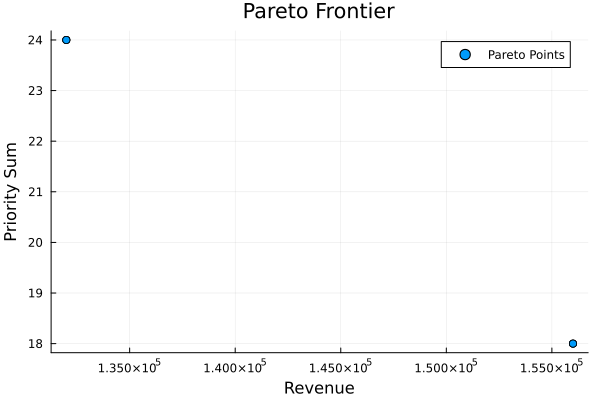

In [7]:
using Plots
println(REV)
println(PRI)
println(OBJ)

p = plot(
    REV,
    PRI,
    seriestype=:scatter,
    label="Pareto Points",
    xlabel="Revenue",
    ylabel="Priority Sum",
    title="Pareto Frontier"
)



In [ ]:
To identify the best lambda, we created a Pareto Frontier consisting of 5 value of lambda: 0, 100, 1000, 5000, 10000, and 100000.

We found that across this list of lambda, only two optimal points were identified. For labmda less than or equal to 1000, the optimal coordinates of each dimension (Revenue, Priority) was (156000, 180). For lambda greater than 24, the optimal coordinates are (132000, 24).  

$$\Large \text{Conculsion}$$

Overall, if Gerald wants to maximize profits, he should choose projects P5, P19, P16, P19, P20, and P22. Instead, if Gerald wishes to have a multi-objective function looking at both revenue and priority, he should choose projects ____. A few more interesting next steps are minimizing the overall deadline, and adding robustness. 

Currently, the total deadline is set at 30 days. However, the deadline be balanced with revenue either reducing the deadline necessary or expanding it. A negative weight would be assigned to the deadline since the objective function is a maximum. 

Additionally, machines can breakdown and events can cause workers to miss work. Establishing a probability for the events to occur and then minimizing the probability could add robustness into the scheduler ensuring that Northrop Gorrila can finish the projects it took on. 